In [2]:
# Numpy and Pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from numpy import mean
from numpy import std
import time
from  Self_Attention import *
# Iterative Stratification untuk cross validation multilabel
from skmultilearn.model_selection import IterativeStratification
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support, roc_curve
#Import Tensorflow dan extension
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.optimizers import Adam, Nadam, Adagrad, SGD, RMSprop, Adadelta
import xgboost as xgb
#Import keras tuner dan metrics untuk tuning parameter
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Sklearn
from sklearn import metrics
import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import StratifiedKFold,KFold
from skopt import BayesSearchCV
import time

#
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

D:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#Fungsi model SAE
def sae_model(xt, xv = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam", 
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5,
              verbose = 0,return_fe = False):
  #Setting result placeholders
  xt_ae = [] ;xv_ae = [] ; w_ae = []
  #If validation set is not present, use train set as validation set
  if xv is None :
    xv = xt.copy()
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate

  #Stacked Autoencoder architecture
  for n_layers in range(num_layers):
    #Autoencoder
    inp = Input(shape=(xt.shape[1],))
    #Apply Dropout
    hidden_layer = Dropout(do)(inp)
    #Layer encoder (jumlah layer sesuai dengan n_layers)
    enc = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)  
    #Layer Decoder
    dec = Dense(xt.shape[1],activation="linear")(enc)
    ae = Model(inp, dec)
    #Compile model
    ae.compile(optimizer=opt, loss='mean_squared_error')
    #EarlyStop jika sudah konvergen 
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=verbose)
    #Latih model
    ae.fit(xt, xt, 
           epochs=EPOCHS,batch_size=BATCH_SIZE, 
           shuffle=True, callbacks = [es] , verbose = verbose,
           validation_data = (xv,xv))
    #Ekstrak Feature extraction
    fe = Model(ae.input, enc)
    #Simpan data hasil latih
    xt = fe.predict(xt) ; xt_ae.append(xt)
    xv = fe.predict(xv) ; xv_ae.append(xv)
    #Simpan bobot hasil latih SAE
    w_ae.append([layer_name for layer_name in ae.layers if "dense" in layer_name.name][0].get_weights())
    if verbose:
      print("Layer {} trained".format(n_layers+1))

  return (w_ae,xv) if return_fe else w_ae

In [4]:
#Fungsi DNN
def dnn_model(xt, n_outputs = 1, sae_weights = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam",
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5):
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate
  
  #Model architecture
  input_layer = Input(shape=(xt.shape[1],))
  hidden_layer = BatchNormalization()(input_layer)
  hidden_layer = Dropout(do)(hidden_layer)
#Set jumlah hidden layer
  for n_layers in range(num_layers):
    hidden_layer = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(do)(hidden_layer)
  output_layer = Dense(n_outputs, activation = 'sigmoid')(hidden_layer)
#latih model
  dnn = Model(input_layer, output_layer)

  #Latih model DNN dengan bobot SAE (jika bobot ada)
  if sae_weights is not None:
    weights = sae_weights
    dnn_dense = [layer_name for layer_name in dnn.layers if "dense" in layer_name.name]
    for weight_from,weight_to in list(zip(weights,dnn_dense)):
      weight_to.set_weights(weight_from)

  #Compile model
  dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics = [
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()],
               )
  return dnn

## Initial Dataset (Feature = Intrinsic Disorder + PSSM)

In [4]:
dataset = pd.read_csv('E:\Projek Pak Wisnu\Projek Peptide-Protein Interaction\dataset_pepPi_cancer_biner.csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [5]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,590_y,591_y,592_y,593_y,594_y,595_y,596_y,597_y,598_y,599_y
0,5xxk_c,P26038_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.0542,0.2475,0.0205,0.2325,0.0304,0.2325,0.0327,0.2167,0.0514,0.2167
1,3u5n_c,P29375_A,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,...,0.3762,0.3295,0.3392,0.3152,0.4149,0.3152,0.4507,0.3051,0.4879,0.3051
2,3kmg_b,O60885_A,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.9009,0.4683,0.9657,0.4433,0.9162,0.4433,0.9606,0.4266,0.9103,0.4266
3,3v9y_b,Q00987_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.0526,0.3261,0.2193,0.3301,0.0858,0.3301,0.1611,0.3429,0.0526,0.3429
4,1jsp_a,P43405_A,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,...,0.0387,0.4071,0.1323,0.3973,0.0660,0.3973,0.2002,0.3908,0.1117,0.3908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7onb_f,P55197_B,-0.433684,0.105263,-1.892632,-0.434342,-1.187368,-0.194868,-0.710000,-0.555789,...,0.0028,0.0031,0.0104,0.0045,0.0012,0.0045,0.0148,0.0058,0.0026,0.0058
53728,5b76_b,Q15276_B,-0.456733,0.190000,-1.202267,-0.417733,-2.709267,-0.310400,-0.964400,-0.335000,...,0.2209,0.4139,0.3019,0.4128,0.2080,0.4128,0.3910,0.4157,0.2913,0.4157
53729,1gwq_c,P37231_B,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,...,0.1844,0.3828,0.3566,0.3856,0.2558,0.3856,0.3631,0.3871,0.2531,0.3871
53730,5o45_b,Q9NZQ7_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.0131,0.0707,0.0157,0.0861,0.0218,0.0861,0.0157,0.0994,0.0200,0.0994


In [6]:
Y=dataset['class']
Y

0        0
1        0
2        0
3        0
4        0
        ..
53727    0
53728    0
53729    0
53730    1
53731    0
Name: class, Length: 53732, dtype: int64

In [7]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X_pepi,Y)

In [8]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(2424, 1202) (2424,)
0    2020
1     404
Name: class, dtype: int64


,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,590_y,591_y,592_y,593_y,594_y,595_y,596_y,597_y,598_y,599_y
0,1t4f_p,P40337_V,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,...,0.8857,0.8676,0.9473,0.8613,0.8945,0.8613,0.9329,0.8465,0.8713,0.8465
1,2lxs_b,P27540_B,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.6293,0.7424,0.6089,0.7413,0.5549,0.7413,0.5382,0.7275,0.5126,0.7275
2,1lkk_b,P30622_A,-2.666667,-0.020833,-7.666667,-13.604167,-19.687500,-1.333333,-4.916667,-0.187500,...,0.5711,0.4130,0.6851,0.4219,0.5667,0.4219,0.6136,0.4316,0.5173,0.4316
3,5j9s_b,Q00610_A,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,-0.471090,...,0.2292,0.3462,0.2988,0.3474,0.3096,0.3474,0.3667,0.3471,0.3668,0.3471
4,2g1t_e,P26196_B,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0.7079,0.4391,0.8198,0.4230,0.6944,0.4230,0.8162,0.4065,0.6906,0.4065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,5cj6_b,P10275_A,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.7342,0.9944,0.8853,0.9953,0.7275,0.9953,0.8530,0.9956,0.6944,0.9956
2420,3tkz_p,Q06124_A,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.2820,0.3980,0.3599,0.3950,0.2483,0.3950,0.3599,0.3936,0.2432,0.3936
2421,4nmp_c,Q9HD26_A,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.1766,0.3296,0.2575,0.3309,0.1602,0.3309,0.2364,0.3342,0.1416,0.3342
2422,2l1l_a,O14980_B,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.4781,0.2822,0.4507,0.2911,0.4458,0.2911,0.3356,0.3020,0.3359,0.3020


In [8]:
X_res = df_res.drop(['pdb_chain', 'Uniprot_chain'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_y,591_y,592_y,593_y,594_y,595_y,596_y,597_y,598_y,599_y
0,-0.433684,0.105263,-1.892632,-0.434342,-1.187368,-0.194868,-0.710000,-0.555789,-1.481711,-0.860658,...,0.1844,0.3828,0.3566,0.3856,0.2558,0.3856,0.3631,0.3871,0.2531,0.3871
1,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.1266,0.3884,0.0555,0.3791,0.0643,0.3791,0.0483,0.3662,0.0502,0.3662
2,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.8457,0.8292,0.9649,0.7997,0.8677,0.7997,0.9433,0.7776,0.8283,0.7776
3,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.3053,0.3994,0.2002,0.4077,0.2041,0.4077,0.2034,0.4179,0.2041,0.4179
4,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.2292,0.3462,0.2988,0.3474,0.3096,0.3474,0.3667,0.3471,0.3668,0.3471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.0200,0.0461,0.0518,0.0427,0.0336,0.0427,0.0300,0.0398,0.0179,0.0398
2420,-0.433684,0.105263,-1.892632,-0.434342,-1.187368,-0.194868,-0.710000,-0.555789,-1.481711,-0.860658,...,0.0141,0.1284,0.0205,0.1181,0.0167,0.1181,0.0389,0.1114,0.0414,0.1114
2421,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.1766,0.3296,0.2575,0.3309,0.1602,0.3309,0.2364,0.3342,0.1416,0.3342
2422,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.7342,0.9944,0.8853,0.9953,0.7275,0.9953,0.8530,0.9956,0.6944,0.9956


In [9]:
scaler_all = MinMaxScaler()
X_res_mm = pd.DataFrame(data = scaler_all.fit_transform(X_res), columns = X_res.columns)

In [13]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer pepi.h5")
        

finding sae weights....
done, processing time: 20.047200679779053
Average Result of 5 CV
Accuracy    : 0.83209±0.006
Recall      : 0.13383±0.041
Precision   : 0.49472±0.070
ROC-AUC     : 0.55280±0.017
F1 Score    : 0.20689±0.049
[[384  20]
 [ 64  16]]


In [15]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train_mm, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_biner_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train_mm, y_train, epochs=100, validation_data=(X_test_mm, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 25s]
val_loss: 0.40811964869499207

Best val_loss So Far: 0.40259823203086853
Total elapsed time: 00h 43m 18s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_biner_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.01
num_layers: 3
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.40259823203086853
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
num_layers: 5
dropout_rate: 0.1
fraction_node: 0.75
Score: 0.4043847620487213
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.01
num_layers: 3
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.40811964869499207
Trial summary
Hyperparameters:
units: 800
learning_rate: 0.01
num_layers: 3
dropout_rate: 0.4
fraction_node: 0.75
Score: 0.4082610607147217
Trial summary
Hyperparameters:
units: 500
learning_rate: 0.01
num_layers: 5
dropout_rate: 0.2
fractio

In [10]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =2000, af = "relu", lr = 0.01, opt =  "adam", num_layers = 3,
                              do = 0.5, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights, hl_node =2000, af = "relu", lr = 0.01, opt =  "adam", num_layers = 3,
                              do = 0.5, fr_node= 0.5)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model1 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model1 = res_all
y_test_model1 = y_test
yhat_model1 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned Cancer pepi.h5")
        

finding sae weights....
done, processing time: 28.05791401863098
Average Result of 5 CV
Accuracy    : 0.82550±0.005
Recall      : 0.13614±0.046
Precision   : 0.42975±0.040
ROC-AUC     : 0.64795±0.030
F1 Score    : 0.20222±0.053
[[392  12]
 [ 69  11]]


# AAC AAC

In [11]:
dataset = pd.read_csv('E:/temp/feature2_2_aac.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,4djs_b,Q9UMX1_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
1,4u7t_f,Q9UMX1_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
2,2pkl_b,Q9UMX1_A,0,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
3,6vdb_h,Q9UMX1_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
4,7tbh_a,Q9UMX1_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53728,1t08_b,Q00610_A,0,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53729,4oed_b,Q00610_A,0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53730,5wgd_f,Q00610_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194


In [12]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,4djs_b,Q9UMX1_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
1,4u7t_f,Q9UMX1_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
2,2pkl_b,Q9UMX1_A,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
3,6vdb_h,Q9UMX1_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
4,7tbh_a,Q9UMX1_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53728,1t08_b,Q00610_A,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,-0.696281,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53729,4oed_b,Q00610_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53730,5wgd_f,Q00610_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194


In [13]:
Y=dataset['class']
Y

0        0
1        0
2        0
3        0
4        0
        ..
53727    0
53728    0
53729    0
53730    0
53731    0
Name: class, Length: 53732, dtype: int64

In [14]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X_pepi,Y)

In [22]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(2424, 1242) (2424,)
0    2020
1     404
Name: class, dtype: int64


,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,7kjm_b,Q15276_B,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.024362,0.033643,0.015081,0.103248,0.056845,0.073086,0.039443,0.049884,0.005800,0.012761
1,3kmg_b,O15550_A,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.017131,0.064954,0.061385,0.061385,0.033547,0.099929,0.060671,0.051392,0.017131,0.029265
2,4nmp_c,Q15022_B,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.027064,0.060893,0.050068,0.047361,0.056834,0.083897,0.060893,0.048714,0.006766,0.020298
3,5wlb_c,P41182_A,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,...,0.026912,0.048159,0.092068,0.035411,0.063739,0.104816,0.048159,0.041076,0.001416,0.031161
4,2lxs_b,P42566_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.012277,0.045759,0.071429,0.050223,0.027902,0.108259,0.051339,0.054688,0.007812,0.010045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,6roy_d,Q06124_A,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.023609,0.045531,0.042159,0.052277,0.062395,0.059022,0.064081,0.075885,0.011804,0.038786
2420,4pky_b,P27540_A,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,...,0.026616,0.044360,0.074778,0.079848,0.060837,0.107731,0.073511,0.059569,0.008872,0.015209
2421,7lwh_b,P35240_A,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210
2422,4zri_c,P35240_A,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210


In [15]:
X_res = df_res.drop(['pdb_chain', 'Uniprot_chain'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.024362,0.033643,0.015081,0.103248,0.056845,0.073086,0.039443,0.049884,0.005800,0.012761
1,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,-0.840000,-0.833136,...,0.017131,0.064954,0.061385,0.061385,0.033547,0.099929,0.060671,0.051392,0.017131,0.029265
2,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.027064,0.060893,0.050068,0.047361,0.056834,0.083897,0.060893,0.048714,0.006766,0.020298
3,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,-0.590726,-0.586221,...,0.026912,0.048159,0.092068,0.035411,0.063739,0.104816,0.048159,0.041076,0.001416,0.031161
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.012277,0.045759,0.071429,0.050223,0.027902,0.108259,0.051339,0.054688,0.007812,0.010045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.023609,0.045531,0.042159,0.052277,0.062395,0.059022,0.064081,0.075885,0.011804,0.038786
2420,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,-0.773281,-0.521951,...,0.026616,0.044360,0.074778,0.079848,0.060837,0.107731,0.073511,0.059569,0.008872,0.015209
2421,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,-1.352224,-0.802342,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210
2422,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,-0.738544,-0.635670,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210


In [16]:
scaler_all = MinMaxScaler()
X_res_mm = pd.DataFrame(data = scaler_all.fit_transform(X_res), columns = X_res.columns)

In [17]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer pepi.h5")
        

finding sae weights....
done, processing time: 17.45453453063965
Average Result of 5 CV
Accuracy    : 0.84035±0.016
Recall      : 0.26253±0.076
Precision   : 0.55082±0.104
ROC-AUC     : 0.60924±0.036
F1 Score    : 0.34935±0.081
[[389  15]
 [ 54  26]]


In [27]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train_mm, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train_mm, y_train, epochs=100, validation_data=(X_test_mm, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 18s]
val_loss: 0.40443921089172363

Best val_loss So Far: 0.3733687102794647
Total elapsed time: 00h 39m 22s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 3
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.3733687102794647
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 3
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.37472817301750183
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.75
Score: 0.37838777899742126
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
num_layers: 3
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.3807028830051422
Trial summary
Hyperparameters:
units: 800
learning_r

In [18]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.02, opt =  "adam", num_layers = 3,
                              do = 0.2, fr_node= 0.75)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.02, opt =  "adam", num_layers = 3,
                              do = 0.2, fr_node= 0.75)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model2 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model2 = res_all
y_test_model2 = y_test
yhat_model2 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned AAC Cancer pepi.h5")
        

finding sae weights....
done, processing time: 11.963365077972412
Average Result of 5 CV
Accuracy    : 0.83128±0.024
Recall      : 0.34173±0.062
Precision   : 0.50956±0.094
ROC-AUC     : 0.72320±0.036
F1 Score    : 0.40256±0.058
[[387  17]
 [ 48  32]]


## DPC DPC

In [19]:
dataset = pd.read_csv('E:/temp/feature2_2_dpc.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,4djs_b,Q9UMX1_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
1,4u7t_f,Q9UMX1_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
2,2pkl_b,Q9UMX1_A,0,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
3,6vdb_h,Q9UMX1_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
4,7tbh_a,Q9UMX1_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53728,1t08_b,Q00610_A,0,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53729,4oed_b,Q00610_A,0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53730,5wgd_f,Q00610_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792


In [20]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,4djs_b,Q9UMX1_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
1,4u7t_f,Q9UMX1_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
2,2pkl_b,Q9UMX1_A,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
3,6vdb_h,Q9UMX1_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
4,7tbh_a,Q9UMX1_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53728,1t08_b,Q00610_A,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,-0.696281,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53729,4oed_b,Q00610_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53730,5wgd_f,Q00610_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792


In [21]:
Y=dataset['class']
Y

0        0
1        0
2        0
3        0
4        0
        ..
53727    0
53728    0
53729    0
53730    0
53731    0
Name: class, Length: 53732, dtype: int64

In [22]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X_pepi,Y)

In [46]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(2424, 2002) (2424,)
0    2020
1     404
Name: class, dtype: int64


,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,7kjm_b,Q15276_B,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.000000,0.001161,0.000000,0.000000,0.003484,0.000000,0.000000,0.002323,0.000000,0.000000
1,3kmg_b,O15550_A,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.000714,0.000714,0.002143,0.002143,0.001429,0.001429,0.000000,0.000714,0.001429,0.000714
2,4nmp_c,Q15022_B,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.001355,0.001355,0.000000,0.001355,0.001355,0.005420,0.000000,0.001355,0.000000,0.000000
3,5wlb_c,P41182_A,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,...,0.001418,0.000000,0.001418,0.000000,0.004255,0.011348,0.002837,0.000000,0.000000,0.000000
4,2lxs_b,P42566_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.000000,0.000000,0.001117,0.000000,0.001117,0.000000,0.000000,0.000000,0.000000,0.001117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,6roy_d,Q06124_A,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.003378,0.000000,0.001689,0.000000,0.001689,0.003378,0.003378,0.000000,0.001689,0.003378
2420,4pky_b,P27540_A,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,...,0.000000,0.002538,0.001269,0.001269,0.000000,0.001269,0.000000,0.001269,0.000000,0.000000
2421,7lwh_b,P35240_A,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000
2422,4zri_c,P35240_A,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000


In [47]:
interaksi_notfound_sisa = X_pepi[~X_pepi.isin(df_res)].dropna().reset_index(drop = True)
interaksi_notfound_sisa

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,4djs_b,P22681_B,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
1,4u7t_f,P22681_B,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
2,2pkl_b,P22681_B,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
3,6vdb_h,P22681_B,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
4,7tbh_a,P22681_B,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51303,7oun_b,Q00610_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792
51304,1t08_b,Q00610_A,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,-0.696281,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792
51305,4oed_b,Q00610_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792
51306,5wgd_f,Q00610_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792


In [23]:
X_res = df_res.drop(['pdb_chain', 'Uniprot_chain'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.000000,0.001161,0.000000,0.000000,0.003484,0.000000,0.000000,0.002323,0.000000,0.000000
1,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,-0.840000,-0.833136,...,0.000714,0.000714,0.002143,0.002143,0.001429,0.001429,0.000000,0.000714,0.001429,0.000714
2,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.001355,0.001355,0.000000,0.001355,0.001355,0.005420,0.000000,0.001355,0.000000,0.000000
3,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,-0.590726,-0.586221,...,0.001418,0.000000,0.001418,0.000000,0.004255,0.011348,0.002837,0.000000,0.000000,0.000000
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.000000,0.000000,0.001117,0.000000,0.001117,0.000000,0.000000,0.000000,0.000000,0.001117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.003378,0.000000,0.001689,0.000000,0.001689,0.003378,0.003378,0.000000,0.001689,0.003378
2420,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,-0.773281,-0.521951,...,0.000000,0.002538,0.001269,0.001269,0.000000,0.001269,0.000000,0.001269,0.000000,0.000000
2421,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,-1.352224,-0.802342,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000
2422,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,-0.738544,-0.635670,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000


In [24]:
scaler_all = MinMaxScaler()
X_res_mm = pd.DataFrame(data = scaler_all.fit_transform(X_res), columns = X_res.columns)

In [25]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model3 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model3 = res_all
y_test_model3 = y_test
yhat_model3 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Cancer 2 DPC pepi.h5")
        

finding sae weights....
done, processing time: 13.09935474395752
Average Result of 5 CV
Accuracy    : 0.83292±0.016
Recall      : 0.42806±0.047
Precision   : 0.50224±0.052
ROC-AUC     : 0.73314±0.031
F1 Score    : 0.46042±0.042
[[374  30]
 [ 51  29]]


In [51]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train_mm, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [52]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerDPC2_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train_mm, y_train, epochs=100, validation_data=(X_test_mm, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 09s]
val_loss: 0.4079720973968506

Best val_loss So Far: 0.3940106928348541
Total elapsed time: 00h 25m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerDPC2_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.030000000000000006
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.3940106928348541
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.39414381980895996
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.3945039212703705
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
num_layers: 3
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.3948180675506592
Trial summary
Hyperparameters:
units: 100
learning_rate: 

In [53]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.03, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.03, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Tuned DPC2 Cancer pepi.h5")
        

finding sae weights....
done, processing time: 8.115154266357422
Average Result of 5 CV
Accuracy    : 0.82468±0.031
Recall      : 0.28716±0.098
Precision   : 0.50363±0.100
ROC-AUC     : 0.60967±0.027
F1 Score    : 0.34611±0.058
[[387  17]
 [ 56  24]]


## Feature = ID + PSSM + AMINO + PHYSICO

In [26]:
dataset = pd.read_csv('E:\Projek Pak Wisnu\Projek Peptide-Protein Interaction\dataset_pepPi_cancer_biner+physico+amino.csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [27]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,7lin_b,O43791_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0,0,0,0,0,0,0,0,0,0
1,3vrp_b,P06239_L,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0,0,0,0,0,0,0,0,0,0
2,2ain_b,P55196_A,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,...,6,6,6,6,5,4,5,6,6,1
3,6mlc_e,P23458_A,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,...,0,0,0,0,0,0,0,0,0,0
4,2lsp_a,P22681_B,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,1pic_b,Q09472_B,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,...,4,2,6,1,2,1,3,1,1,4
2420,3t03_c,P04637_A,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,...,0,0,0,0,0,0,0,0,0,0
2421,1t4f_p,P00533_A,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,...,0,0,0,0,0,0,0,0,0,0
2422,4blb_e,P42768_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0,0,0,0,0,0,0,0,0,0


In [28]:
Y=dataset['class']
Y

0       1
1       0
2       1
3       0
4       0
       ..
2419    0
2420    0
2421    0
2422    0
2423    0
Name: class, Length: 2424, dtype: int64

In [29]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,-2.547488,-1.299843,...,0,0,0,0,0,0,0,0,0,0
1,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0,0,0,0,0,0,0,0,0,0
2,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,-0.810000,-0.560000,...,6,6,6,6,5,4,5,6,6,1
3,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,-1.696522,-0.510465,...,0,0,0,0,0,0,0,0,0,0
4,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,-0.810000,-0.560000,...,4,2,6,1,2,1,3,1,1,4
2420,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0,0,0,0,0,0,0,0,0,0
2421,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0,0,0,0,0,0,0,0,0,0
2422,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0,0,0,0,0,0,0,0,0,0


In [30]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:600] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:600]), columns = X_res.iloc[:,:600].columns)
X_res.iloc[:,700:1300] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,700:1300]), columns = X_res.iloc[:,700:1300].columns)

In [36]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2420,0.910712,0.860648,0.989790,0.976101,0.958756,0.901133,0.938220,0.766081,0.955970,0.947555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2421,0.918353,0.866344,0.997379,0.964507,0.951265,0.778771,0.834809,0.733123,0.863165,0.766247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2422,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,0,0,0,0,0,0,0,0,0,0
1,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0,0,0,0,0,0,0,0,0,0
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0,0,0,0,0,0,0,0,0,0
3,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0,0,0,0,0,0,0,0,0,0
4,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,4,4,5,5,4,4,5,6,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0,0,0,0,0,0,0,0,0,0
2420,0.910712,0.860648,0.989790,0.976101,0.958756,0.901133,0.938220,0.766081,0.955970,0.947555,...,1,5,1,4,5,1,1,4,4,5
2421,0.918353,0.866344,0.997379,0.964507,0.951265,0.778771,0.834809,0.733123,0.863165,0.766247,...,0,0,0,0,0,0,0,0,0,0
2422,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0,0,0,0,0,0,0,0,0,0


In [31]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [66]:
X_res_mm

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0,0,0,0,0,0,0,0,0,0
1,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0,0,0,0,0,0,0,0,0,0
2,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,6,6,6,6,5,4,5,6,6,1
3,0.999500,0.739548,0.772856,0.952016,0.988605,0.802936,0.869836,0.794647,0.691187,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,4,2,6,1,2,1,3,1,1,4
2420,0.978385,0.704064,0.738576,0.940583,0.977296,0.738653,0.836539,0.770945,0.581756,0.874757,...,0,0,0,0,0,0,0,0,0,0
2421,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0,0,0,0,0,0,0,0,0,0
2422,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO pepi.h5")
        

finding sae weights....
done, processing time: 49.15298891067505
Average Result of 5 CV
Accuracy    : 0.83086±0.013
Recall      : 0.28472±0.035
Precision   : 0.49427±0.061
ROC-AUC     : 0.61241±0.017
F1 Score    : 0.35917±0.036
[[381  23]
 [ 55  25]]


In [21]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 00m 52s]
val_loss: 0.4361476004123688

Best val_loss So Far: 0.41587209701538086
Total elapsed time: 00h 26m 25s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.41587209701538086
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 2
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.4171868562698364
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
num_layers: 2
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.4178392291069031
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 2
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.41820284724235535
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020

In [32]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model4 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model4 = res_all
y_test_model4 = y_test
yhat_model4 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned PHYSICO AMINO Cancer pepi.h5")
        

finding sae weights....
done, processing time: 19.633167028427124
Average Result of 5 CV
Accuracy    : 0.82550±0.020
Recall      : 0.34910±0.062
Precision   : 0.49445±0.091
ROC-AUC     : 0.72683±0.013
F1 Score    : 0.39766±0.035
[[374  30]
 [ 49  31]]


## NEW 2 AAC 

In [33]:
dataset = pd.read_csv('E:/temp/feature3_2_aac.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,1o9k_p,P55197_B,0,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,4ajy_h,P55197_B,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,4nmq_c,P55197_B,0,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,5nng_b,P55197_B,0,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,5jjm_m,P55197_B,0,-9.000000,0.000000,-9.000000,-9.000000,-2.250000,-0.250000,-1.000000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,3v9y_b,P04233_I,0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,1t65_b,P04233_I,0,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,5dah_c,P04233_I,0,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,7aos_c,P04233_I,0,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [34]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,1o9k_p,P55197_B,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,4ajy_h,P55197_B,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,4nmq_c,P55197_B,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,5nng_b,P55197_B,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,5jjm_m,P55197_B,-9.000000,0.000000,-9.000000,-9.000000,-2.250000,-0.250000,-1.000000,-0.250000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,3v9y_b,P04233_I,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,1t65_b,P04233_I,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,5dah_c,P04233_I,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,7aos_c,P04233_I,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [35]:
Y=dataset['class']
Y.sum(0)

404

In [36]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,-9.000000,0.000000,-9.000000,-9.000000,-2.250000,-0.250000,-1.000000,-0.250000,-1.000000,-1.000000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,-2.547488,-1.299843,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,-0.840000,-0.833136,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [37]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:600] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:600]), columns = X_res.iloc[:,:600].columns)
X_res.iloc[:,700:1300] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,700:1300]), columns = X_res.iloc[:,700:1300].columns)

In [23]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.978385,0.704064,0.738576,0.940583,0.977296,0.738653,0.836539,0.770945,0.581756,0.874757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.831461,0.043784,0.343998,0.934373,0.862736,0.857272,0.929011,0.873022,0.736427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2420,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2421,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2422,0.988533,0.940338,0.928844,0.985093,0.913767,0.863142,0.877942,0.877964,0.914791,0.826269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,0.978385,0.704064,0.738576,0.940583,0.977296,0.738653,0.836539,0.770945,0.581756,0.874757,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,0.000000,0.831461,0.043784,0.343998,0.934373,0.862736,0.857272,0.929011,0.873022,0.736427,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,0.988533,0.940338,0.928844,0.985093,0.913767,0.863142,0.877942,0.877964,0.914791,0.826269,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [38]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [74]:
X_res_mm
Y

0       0
1       0
2       0
3       0
4       0
       ..
2419    0
2420    0
2421    0
2422    0
2423    0
Name: class, Length: 2424, dtype: int64

In [27]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 pepi.h5")
        

finding sae weights....
done, processing time: 33.40499424934387
Average Result of 5 CV
Accuracy    : 0.82260±0.015
Recall      : 0.42623±0.147
Precision   : 0.48205±0.062
ROC-AUC     : 0.66411±0.053
F1 Score    : 0.43179±0.073
[[338  66]
 [ 30  50]]


In [28]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC2_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 35s]
val_loss: 0.36009225249290466

Best val_loss So Far: 0.36009225249290466
Total elapsed time: 00h 48m 35s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC2_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.1
num_layers: 5
dropout_rate: 0.1
fraction_node: 0.66
Score: 0.36009225249290466
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.09000000000000001
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.75
Score: 0.360589861869812
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.09000000000000001
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.75
Score: 0.370216965675354
Trial summary
Hyperparameters:
units: 800
learning_rate: 0.05000000000000001
num_layers: 4
dropout_rate: 0.30000000000000004
fraction_node: 0.5
Score: 0.37183502316474915
Trial summary
Hyperparameters:
units: 800

In [39]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.01, opt =  "adam", num_layers = 5,
                              do = 0.1, fr_node= 0.66)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.01, opt =  "adam", num_layers = 5,
                              do = 0.1, fr_node= 0.66)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model5 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model5 = res_all
y_test_model5 = y_test
yhat_model5 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned AAC2 Cancer pepi.h5")
        

finding sae weights....
done, processing time: 27.67356514930725
Average Result of 5 CV
Accuracy    : 0.82220±0.035
Recall      : 0.49506±0.014
Precision   : 0.48566±0.089
ROC-AUC     : 0.76160±0.024
F1 Score    : 0.48600±0.047
[[360  44]
 [ 40  40]]


In [5]:
# UJI VIPER
from tensorflow.keras.models import load_model
sae_dnn_model5 = load_model('SAE-DNN PubChem Biner Tuned AAC2 Cancer pepi.h5')
# summarize model.
sae_dnn_model5.summary()

Model: "functional_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 4222)]            0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 4222)              16888     
_________________________________________________________________
dropout_138 (Dropout)        (None, 4222)              0         
_________________________________________________________________
dense_157 (Dense)            (None, 100)               422300    
_________________________________________________________________
batch_normalization_120 (Bat (None, 100)               400       
_________________________________________________________________
dropout_139 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 66)             

In [35]:
viper_uji = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/data_uji_feature_all.csv')
viper_uji_tomodel = viper_uji.drop(['pdb_chain','Uniprot_chain'], axis=1)
viper_uji_tomodel

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23920,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,-1.696522,-0.510465,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
23921,-1.350000,-0.555556,-4.450000,-7.688889,-6.950000,-1.505556,-3.600000,-0.088889,-0.605556,-0.738889,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
23922,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
23923,-1.350000,-0.555556,-4.450000,-7.688889,-6.950000,-1.505556,-3.600000,-0.088889,-0.605556,-0.738889,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [36]:
#Predict data herbal
yhat_viper_proba =  sae_dnn_model5.predict(viper_uji_tomodel)
# Bulatkan probabilitas 
yhat_viper = yhat_viper_proba.round()
yhat_viper

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [14]:
yhat_viper_proba

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [37]:
viper_uji_predicted = viper_uji[['pdb_chain','Uniprot_chain']]
viper_uji_predicted['class']=yhat_viper
viper_uji_predicted['class_proba']=yhat_viper_proba


C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_12012\3216545669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class']=yhat_viper
C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_12012\3216545669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class_proba']=yhat_viper_proba


In [38]:
viper_1_only = viper_uji_predicted[viper_uji_predicted['class_proba']>0.5]
# .to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_predicted_class1_only.csv',index=False)

In [39]:
train_pairs = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/train_pairs_cancer+drugbank.csv')
prot_info = train_pairs[['Uniprot_id','Uniprot_chain','pep_seq','prot_seq']]
prot_info2 = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/frequently-mutated-genes cancer.csv')
prot_info2

,Symbol,Name,Annotations,Survival,Uniprot_id
0,5-Sep,septin 5,Cancer Gene Census,add to survival plot,Q99719
1,6-Sep,septin 6,Cancer Gene Census,add to survival plot,Q14141
2,9-Sep,septin 9,Cancer Gene Census,add to survival plot,Q9UHD8
3,ABI1,abl-interactor 1,Cancer Gene Census,add to survival plot,Q8IZP0
4,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",Cancer Gene Census,add to survival plot,P00519
...,...,...,...,...,...
567,ZMYM2,"zinc finger, MYM-type 2",Cancer Gene Census,add to survival plot,Q9UBW7
568,ZNF331,zinc finger protein 331,Cancer Gene Census,add to survival plot,Q9NQX6
569,ZNF384,zinc finger protein 384,Cancer Gene Census,add to survival plot,Q8TF68
570,ZNF521,zinc finger protein 521,Cancer Gene Census,add to survival plot,Q96K83


In [40]:
pd.merge(pd.merge(viper_1_only,prot_info,how="inner",on="Uniprot_chain").drop_duplicates(subset=['pdb_chain','Uniprot_chain','Uniprot_id']),prot_info2[['Symbol','Name','Uniprot_id']],how="inner",on='Uniprot_id').to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_predicted_class1_only_withproteininfo2.csv',index=False)

## DATASET PHYSIC AMINO + DRUGBANK

In [40]:
dataset = pd.read_csv('E:\Projek Pak Wisnu\Projek Peptide-Protein Interaction\dataset_pepPi_cancer_+drugbank(pssm_aac).csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [41]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,6qg8_b,P25791_A,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,...,0,0,0,0,0,0,0,0,0,0
1,2xjz_i,P84022_A,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,...,0,0,0,0,0,0,0,0,0,0
2,5hyn_e,O15550_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0,0,0,0,0,0,0,0,0,0
3,2kwf_b,Q9ULV8_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0,0,0,0,0,0,0,0,0,0
4,6oie_c,P09619,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2n3a_a,O75376_A,-0.615556,-1.039365,-3.268571,-1.040000,-1.725714,-1.096508,-1.363175,-0.753651,...,6,2,6,4,5,5,1,6,1,2
2638,6mim_b,P06239_L,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0,0,0,0,0,0,0,0,0,0
2639,1gxc_b,O43791_A,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0,0,0,0,0,0,0,0,0,0
2640,5nwm_b,Q15788_A,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,...,6,4,1,1,4,4,1,1,4,5


In [42]:
Y=dataset['class']
Y

0       0
1       0
2       0
3       0
4       0
       ..
2637    0
2638    0
2639    0
2640    1
2641    0
Name: class, Length: 2642, dtype: int64

In [43]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,-1.352224,-0.802342,...,0,0,0,0,0,0,0,0,0,0
1,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,-0.722764,-0.636573,...,0,0,0,0,0,0,0,0,0,0
2,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0,0,0,0,0,0,0,0,0,0
3,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0,0,0,0,0,0,0,0,0,0
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.615556,-1.039365,-3.268571,-1.040000,-1.725714,-1.096508,-1.363175,-0.753651,-2.438413,-1.034603,...,6,2,6,4,5,5,1,6,1,2
2638,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0,0,0,0,0,0,0,0,0,0
2639,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0,0,0,0,0,0,0,0,0,0
2640,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,-0.738544,-0.635670,...,6,4,1,1,4,4,1,1,4,5


In [44]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:600] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:600]), columns = X_res.iloc[:,:600].columns)
X_res.iloc[:,700:1300] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,700:1300]), columns = X_res.iloc[:,700:1300].columns)

In [14]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.901855,0.940350,0.959248,0.952197,0.891015,0.988853,0.972002,0.842387,0.945961,0.933323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.997922,0.862380,0.878457,0.975669,1.000000,0.883076,0.893457,0.834289,0.823963,0.845748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2639,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2640,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,0,0,0,0,0,0,0,0,0,0
1,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0,0,0,0,0,0,0,0,0,0
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0,0,0,0,0,0,0,0,0,0
3,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0,0,0,0,0,0,0,0,0,0
4,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,4,4,5,5,4,4,5,6,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0,0,0,0,0,0,0,0,0,0
2420,0.910712,0.860648,0.989790,0.976101,0.958756,0.901133,0.938220,0.766081,0.955970,0.947555,...,1,5,1,4,5,1,1,4,4,5
2421,0.918353,0.866344,0.997379,0.964507,0.951265,0.778771,0.834809,0.733123,0.863165,0.766247,...,0,0,0,0,0,0,0,0,0,0
2422,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0,0,0,0,0,0,0,0,0,0


In [45]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [24]:
len(y_train[y_train==0])

1752

In [16]:
weight_for_0 = (1 / len(dataset[dataset['class']==0])) * (len(dataset) / 2.0)
weight_for_1 = (1 / len(dataset[dataset['class']==1])) * (len(dataset) / 2.0)

class_weight_sae = {0: weight_for_0, 1: weight_for_1}
class_weight_sae

{0: 0.6031963470319635, 1: 2.922566371681416}

In [46]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
    weight_for_0 = (1 / len(y_train[y_train==0])) * (len(y_train) / 2.0)
    weight_for_1 = (1 / len(y_train[y_train==1])) * (len(y_train) / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model6 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model6 = res_all
y_test_model6 = y_test
yhat_model6 = yhat_proba

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO DrugBank pepi.h5")
        

finding sae weights....
done, processing time: 38.13830280303955
Average Result of 5 CV
Accuracy    : 0.80470±0.003
Recall      : 0.43346±0.079
Precision   : 0.42852±0.011
ROC-AUC     : 0.73883±0.021
F1 Score    : 0.42822±0.043
[[390  48]
 [ 53  37]]


In [31]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [1000,1200,1500,1800,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_DrugBank_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 07s]
val_loss: 0.4373379945755005

Best val_loss So Far: 0.3956456780433655
Total elapsed time: 01h 19m 37s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_DrugBank_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.07
num_layers: 5
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.3956456780433655
Trial summary
Hyperparameters:
units: 800
learning_rate: 0.030000000000000006
num_layers: 3
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.3973102271556854
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.07
num_layers: 5
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.40380749106407166
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.40950095653533936
Trial summary
Hyperparameters:
units: 500
learning_ra

In [20]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.07, opt =  "adam", num_layers = 5,
                              do = 0.1, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.07, opt =  "adam", num_layers = 5,
                              do = 0.1, fr_node= 0.5)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Tuned PHYSICO AMINO DrugBank Cancer pepi.h5")
        

finding sae weights....
done, processing time: 23.318960905075073
Average Result of 5 CV
Accuracy    : 0.82096±0.007
Recall      : 0.32962±0.063
Precision   : 0.47060±0.029
ROC-AUC     : 0.62600±0.024
F1 Score    : 0.38310±0.042
[[408  30]
 [ 63  27]]


## DrugBank 2 AAC

In [47]:
dataset = pd.read_csv('E:/temp/feature4_2_aac.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,2e4h_b,P21802_A,0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,2mjv_a,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,3lqi_r,P21802_A,0,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,3l3x_b,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,1r2b_c,P21802_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2mv7_b,Q7KZF4_A,0,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,3omc_c,Q7KZF4_A,1,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,1yvh_b,Q7KZF4_A,0,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,6xzz_b,Q7KZF4_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [48]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,2e4h_b,P21802_A,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,2mjv_a,P21802_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,3lqi_r,P21802_A,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,3l3x_b,P21802_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,1r2b_c,P21802_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2mv7_b,Q7KZF4_A,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,-0.471090,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,3omc_c,Q7KZF4_A,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,-1.673469,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,1yvh_b,Q7KZF4_A,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,6xzz_b,Q7KZF4_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [49]:
Y=dataset['class']
Y.sum(0)

452

In [50]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,-0.722764,-0.636573,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,-0.471090,-1.207201,-0.793554,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,-1.673469,-0.513605,-1.336735,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [51]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:600] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:600]), columns = X_res.iloc[:,:600].columns)
X_res.iloc[:,700:1300] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,700:1300]), columns = X_res.iloc[:,700:1300].columns)

In [88]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [52]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [34]:
X_res_mm
Y

0       0
1       0
2       0
3       0
4       0
       ..
2637    0
2638    1
2639    0
2640    0
2641    0
Name: class, Length: 2642, dtype: int64

In [53]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
    weight_for_0 = (1 / len(y_train[y_train==0])) * (len(y_train) / 2.0)
    weight_for_1 = (1 / len(y_train[y_train==1])) * (len(y_train) / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model7 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model7 = res_all
y_test_model7 = y_test
yhat_model7 = yhat_proba

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 drugbank pepi.h5")
        

finding sae weights....
done, processing time: 51.326141595840454
Average Result of 5 CV
Accuracy    : 0.81833±0.020
Recall      : 0.35849±0.118
Precision   : 0.48044±0.094
ROC-AUC     : 0.73609±0.025
F1 Score    : 0.39314±0.084
[[428  10]
 [ 73  17]]


In [39]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [1000,1200,1500,1800,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [40]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=25,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC2_DrugBank_Cancer', overwrite = True)
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 25 Complete [00h 01m 23s]
val_loss: 0.4349260628223419

Best val_loss So Far: 0.4206862449645996
Total elapsed time: 01h 44m 35s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC2_DrugBank_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.06000000000000001
num_layers: 4
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.4206862449645996
Trial summary
Hyperparameters:
units: 1800
learning_rate: 0.030000000000000006
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.75
Score: 0.42997482419013977
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.06000000000000001
num_layers: 4
dropout_rate: 0.30000000000000004
fraction_node: 0.66
Score: 0.4301125109195709
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.06000000000000001
num_layers: 5
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.43192973732948303
Trial summ

In [41]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =2000, af = "relu", lr = 0.06, opt =  "adam", num_layers = 4,
                              do = 0.2, fr_node= 0.75)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =2000, af = "relu", lr = 0.06, opt =  "adam", num_layers = 4,
                              do = 0.2, fr_node= 0.75)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100, class_weight = class_weight)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Tuned AAC2 Cancer Drugbank pepi.h5")
        

finding sae weights....
done, processing time: 61.565351724624634
Average Result of 5 CV
Accuracy    : 0.61917±0.203
Recall      : 0.54298±0.305
Precision   : 0.25047±0.088
ROC-AUC     : 0.58907±0.070
F1 Score    : 0.29875±0.151
[[ 48 390]
 [  4  86]]


## Feature selection with RF and XGB

In [41]:
dataset = pd.read_csv('E:/temp/feature4_2_aac.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,2e4h_b,P21802_A,0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,2mjv_a,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,3lqi_r,P21802_A,0,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,3l3x_b,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,1r2b_c,P21802_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2mv7_b,Q7KZF4_A,0,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,3omc_c,Q7KZF4_A,1,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,1yvh_b,Q7KZF4_A,0,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,6xzz_b,Q7KZF4_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [42]:
Y=dataset['class']
Y.sum(0)

452

In [43]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,-0.722764,-0.636573,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,-0.471090,-1.207201,-0.793554,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,-1.673469,-0.513605,-1.336735,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [44]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:600] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:600]), columns = X_res.iloc[:,:600].columns)
X_res.iloc[:,700:1300] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,700:1300]), columns = X_res.iloc[:,700:1300].columns)

In [44]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [45]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [46]:
X_res_mm
Y

0       0
1       0
2       0
3       0
4       0
       ..
2637    0
2638    1
2639    0
2640    0
2641    0
Name: class, Length: 2642, dtype: int64

In [48]:
clf = RandomForestClassifier(random_state=0, class_weight = "balanced")

In [50]:
#Tune Parameter for RF

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
max_depth = [3,4,5,6]
#max feature
max_features = ['auto','sqrt','log2']
#max_samples
max_samples = [x for x in np.linspace(0.1,1,10)]
# create  grid
param_grid = {
'n_estimators': n_estimators,
'max_depth': max_depth,
'max_features': max_features,
'max_samples':max_samples
 }
# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}

# Grid search of parameters
rf_tune = GridSearchCV(estimator = clf, param_grid = param_grid, cv = cv, scoring=scoring, n_jobs=-2, verbose=1, refit='F1')
# Fit the model
rf_tune.fit(X_res_mm, Y)
# print results
print(rf_tune.best_params_)
print(rf_tune.best_score_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'max_depth': 6, 'max_features': 'auto', 'max_samples': 0.9, 'n_estimators': 200}
0.43078485553616436


In [51]:
#Tune Parameter for XGB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

xgbc = xgb.XGBClassifier(random_state=0, class_weight = "balanced")
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}

# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-3, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res_mm, Y)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:22:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
OrderedDict([('colsample_bytree', 1.0), ('eta', 0.8), ('n_estimators', 400)])
0.4600270434759599


In [47]:
clf = RandomForestClassifier( max_depth = 6, n_estimators = 200, max_samples = 0.9, random_state=123)
clf.fit(X_res_mm, Y)
jumlah =0
importance=[]
for i in range(len(X_res_mm.columns)):
    if(clf.feature_importances_[i]>0):
        print(X_res_mm.columns[i],clf.feature_importances_[i])
        importance.append(X_res_mm.columns[i])
        jumlah=jumlah+1
print(jumlah)

0_x 4.65504221843996e-05
1_x 0.0009353317504271431
2_x 0.0008003630782661415
3_x 0.0009082270908918456
4_x 0.0007089386125236914
5_x 0.0003125149616267342
6_x 0.0008690125779063273
7_x 0.0004866341488236119
8_x 0.0005862666758493996
9_x 0.0009253571982621899
10_x 0.0004080719950461631
11_x 0.0011195001569938592
12_x 0.0010432361519116654
13_x 0.0003811105560733717
14_x 0.0008398276380111874
15_x 0.0006772350837249283
16_x 0.00037755805259389555
17_x 0.0012738875286144602
18_x 0.0004767518283255011
19_x 0.00047833766173537685
20_x 0.0006769212271858033
21_x 0.0002606574445363462
22_x 0.0005886499152229944
23_x 0.00056033344184229
24_x 0.0005936371099616015
25_x 0.000375886103947866
26_x 0.00046938492977783805
27_x 0.00043849834480998715
28_x 0.0006479379191441176
29_x 0.0004980533649402805
30_x 0.000990671392919437
31_x 0.0008379870987894746
32_x 0.0007790631912794088
33_x 0.00022634613456348936
34_x 0.00042500451244451893
35_x 0.0018620271782214966
36_x 0.000759270118272079
37_x 0.0008

297_x 0.0004469319212470875
298_x 0.0007040228532676799
299_x 0.0002836376482074418
300_x 0.0005887612973530159
301_x 0.0006699794007993033
302_x 0.0013661771236663722
303_x 0.0004042000411059439
304_x 0.0006885249024455849
305_x 0.0011452483636297357
306_x 0.001036559931651349
307_x 0.0007805453579852055
308_x 0.0013123760305728555
309_x 0.0006353809655975423
310_x 0.0009972373278415757
311_x 0.0004756654453422714
312_x 0.0008557511954425852
313_x 0.0007291421230039855
314_x 0.0007244288225932582
315_x 0.0005180670038808444
316_x 0.000743199637967742
317_x 0.000285071671711187
318_x 0.0007896334957120884
319_x 0.0004922718667755056
320_x 0.001215774126041559
321_x 0.0015803987896971011
322_x 0.0004982191725217125
323_x 0.00036735280870769666
324_x 0.0007109337888991301
325_x 0.0008653189733015215
326_x 0.0008208387922108192
327_x 0.0007659075229151074
328_x 0.000900197054151972
329_x 0.0004757044660577876
330_x 0.000644467519543972
331_x 7.777492186581164e-05
332_x 0.00053232410726534

X25_x 0.0004774070321777485
X26_x 0.00017368697818815435
X27_x 0.0007364815069174002
X28_x 0.00011224366993437747
X29_x 0.00012756486700698036
X30_x 8.825550450915127e-05
X31_x 0.00020309910476179526
X32_x 0.0005657449077476886
X33_x 0.00029412464753492324
X34_x 0.00010379521787981509
X35_x 0.00012321032400492145
X36_x 9.508417104177153e-05
X37_x 7.88041929656513e-05
X38_x 1.8316494534124496e-05
X40_x 0.0001107237850089069
X41_x 1.8843560335105107e-05
X42_x 0.00012776670673501084
X44_x 7.682124569976997e-05
X45_x 8.723268321190131e-05
X47_x 0.0002330368450570558
X48_x 1.9263141788818437e-05
X49_x 9.786224311785009e-05
X50_x 8.977965723932703e-05
Y1_x 0.00039231317359839074
Y2_x 0.0010193445995426264
Y3_x 0.0003894431983935666
Y4_x 0.0014965159304100146
Y5_x 0.0004427810973879722
Y6_x 0.000581886835768662
Y7_x 0.00011075742359766458
Y8_x 0.00021814697795869567
Y9_x 0.0004222467576769244
Y10_x 0.00038201323804097355
Y11_x 0.0002742327832115167
Y12_x 0.00013549502344644185
Y13_x 0.0007256

236_y 0.0001603003255596367
237_y 9.185132213113569e-05
238_y 0.00047482198826155923
239_y 0.0010420808025843348
240_y 0.0004076690756159062
241_y 0.0007391486577243981
242_y 0.0004547338272304815
244_y 0.0003924179921403965
245_y 0.0010977010065189032
246_y 0.000653044514725451
247_y 2.855099545034285e-05
248_y 0.00022107563202504517
249_y 8.357177971498999e-05
250_y 0.001135266052358794
251_y 0.0006147893333820551
252_y 0.00024419086926670916
254_y 0.00018027093898262804
255_y 3.0503852871207472e-06
256_y 9.037438040939806e-05
257_y 7.671972695121707e-05
259_y 0.0001208047244728638
260_y 3.981808155020427e-05
261_y 0.00038296888199168045
262_y 0.00022942233779693012
263_y 0.00014249261447194523
264_y 0.00019139952617270027
265_y 0.0008301046862081692
266_y 0.0003758426192316701
267_y 0.0003609889172712622
268_y 0.002022562311929585
269_y 0.0010211465454844917
270_y 0.0016836189005223668
271_y 0.0007777616401851989
272_y 0.00042153938251173503
273_y 0.00029974771875105764
274_y 0.0007

567_y 0.00025388996436962537
568_y 0.0007889064184691834
569_y 0.00022574881544952272
570_y 7.240292963216478e-05
571_y 0.00011241364721178315
572_y 0.00030017329834049563
573_y 0.0003359168534120107
574_y 0.0002251552480851003
575_y 0.0007524819534560315
576_y 0.002230445489852447
577_y 0.0008677659399004978
578_y 6.382277744960755e-05
579_y 0.00022260051922113903
580_y 0.0011748220340330043
581_y 0.00015075313184568294
582_y 0.0006781409019265797
583_y 0.0009107580238104432
584_y 0.00031521078869866303
586_y 0.0001069370361141317
587_y 0.00034039846035834194
588_y 0.0006896566637445666
589_y 0.0002453136696188139
590_y 0.0008867351072456687
591_y 0.00042713232488111706
592_y 0.00238902654839882
593_y 0.00015026175751989146
594_y 0.0019399524772698257
595_y 0.00010876443763816737
596_y 0.0010070018854295647
597_y 8.753553057454476e-05
598_y 0.0010482152581315185
599_y 0.0002570656855157964
X2_y 0.00017466939432779429
X3_y 0.00026241741295975914
X4_y 0.00014762070198578325
X5_y 1.82714

X315 0.00013384862719434623
X316 0.0011600755235231465
X317 3.840111179135269e-05
X318 0.0005145384149715044
X319 4.49764668884026e-05
X320 4.0799289888254996e-05
X321 0.00019174516328743438
X322 0.00012388374736899837
X323 0.0002218547721782928
X324 0.00013355153329703447
X325 0.00021591489545792617
X326 0.0002736490083959356
X327 3.654171406343209e-05
X328 0.00016744638082693484
X330 0.0004493852940495559
X331 0.00029865394829698116
X334 6.744034067632664e-05
X335 0.0007522729315878982
X339 0.00037987027194814936
X340 0.00034811561359073396
X341 0.00013927639974128
X342 0.00022034167740537635
X343 0.0003508492779523583
X344 0.0002562920278117927
X345 0.00015027489426915676
X347 0.0004804273043147032
X348 1.4145858247079966e-05
X349 0.000330079588588233
X350 0.0016364889043645056
X351 5.652213068559077e-05
X352 4.1334205745154435e-05
X353 0.0006074017918183791
X354 6.246406344988409e-05
X355 0.00043676200432685435
X356 9.82226892584877e-05
X357 4.284239265361033e-05
X358 0.00025627824

X728 0.00047951678514312194
X729 4.054655514598724e-05
X732 0.0003898771917690623
X733 7.06873176326775e-05
X734 0.00019455449508100315
X735 0.00013016610923647455
X739 0.00040381126683681107
X743 0.0001553107273028301
X746 0.0003125177635387641
X747 0.00015269758568040723
X748 0.00027469588895667627
X749 0.0011946754680185285
X750 3.611582166314374e-05
X753 0.0003651669053432166
X754 0.00020480438887183965
X755 1.297263002867651e-05
X756 3.22681464739684e-05
X757 8.099276896155934e-05
X758 4.550343527642909e-05
X759 0.0002264155589456787
X760 0.00019790819818707946
X763 0.00035036508176865895
X764 0.00015795666944461043
X767 0.0002915299805468727
X770 0.00023990114553226058
X774 0.00024523310541011816
X775 4.011977457558945e-05
X776 0.00020954892577989187
X777 0.00026144108974473926
X779 0.00019700628250504622
X783 0.00011139412330014174
X784 5.5483538626222546e-05
X785 0.00013523366856397866
X789 0.00024566450132857667
X793 0.00020587302627946856
X794 0.0001508006799662043
X795 2.060

X1390 0.0002714600324159969
X1391 0.00045903757015691
X1394 0.00016233501261954644
X1397 0.000496294411204609
X1399 7.136953468284565e-06
X1403 0.00036049364254744985
X1404 0.0005710092154297802
X1408 0.0008758237305026878
X1409 7.939739892229857e-05
X1410 0.0004945285051459418
X1411 0.00024497565311095646
X1415 0.00022624635683448442
X1416 4.600881232221854e-06
X1418 6.56774233114372e-05
X1420 0.0003958684036287637
X1422 0.0004232242660140099
X1425 2.253099013717369e-05
X1426 9.54902587916893e-05
X1428 1.3694879325105829e-05
X1436 3.5019525676688813e-06
X1438 0.00010759135144616474
X1441 0.00040614798097648465
Y3_y 0.0004285613224373366
Y6_y 0.00010091974896727951
Y9_y 4.2182338511238514e-05
Y10_y 0.00015586574308339157
Y11_y 0.0001601707857725932
Y12_y 5.5324187266496974e-05
Y15_y 0.0004371111833377628
Y16_y 0.00011098708796780231
Y18_y 0.00021925247143697978
Y19_y 0.0002819262089667094
Y20_y 0.00015005883386293061
Y21_y 0.00022085588850478076
Y23_y 0.00013648783816530422
Y24_y 0.000

Y461 1.932679899506425e-05
Y462 0.00029401228262586863
Y463 0.00015386011425714736
Y464 1.770287018824842e-05
Y465 0.00013146402976746616
Y466 0.00010165392331213802
Y468 5.68331667681326e-05
Y469 0.00021150623615487862
Y471 0.00019707308567069648
Y472 0.0004960421673633496
Y474 0.00012199945822527078
Y475 0.00013724852251198737
Y477 7.204908618291931e-05
Y479 7.735001528332423e-05
Y480 0.00013459829302643923
Y481 7.288058591085939e-05
Y482 0.00013490215158420052
Y484 0.0001523715673226371
Y486 0.00028092506403203603
Y488 0.0005542232091580927
Y489 0.00019625781794452665
Y491 5.2743098344763756e-05
Y492 0.0001252450979713662
Y493 0.00019633957510681728
Y496 0.000243166163066503
Y497 3.1742992827610545e-05
Y498 0.00024165599744794535
Y501 4.1904836736552764e-05
Y502 0.0001061868127618384
Y503 0.00010207156516625184
Y506 0.00013762849075853515
Y507 0.00026956648918331874
Y508 2.405837287024601e-05
Y509 0.00019657629437885084
Y511 0.00021038354566372316
Y514 8.868304725137728e-05
Y515 5.9

Y1298 0.0001166524497676871
Y1309 0.00015981772266879932
Y1325 0.0007116320629393361
Y1327 2.9750465727941843e-05
Y1336 0.00010199735793275342
Y1338 0.00021635024504866647
Y1339 0.00013813439895533179
Y1360 9.22783071036586e-05
Y1361 5.277166801817032e-05
Y1363 0.0006939552847866723
Y1366 5.2545240279574014e-05
Y1368 5.0287887900138235e-05
Y1372 0.0004289215908737879
Y1385 0.000547248196380931
Y1392 0.0004851808105625514
Y1393 0.0001400235486950464
Y1397 1.165858115666942e-05
Y1403 0.00038734163969587833
Y1409 5.5677108659369204e-05
Y1410 5.228453725918757e-05
Y1414 4.228257670543062e-05
Y1419 0.0004877542625286525
Y1425 0.0003365234745058128
Y1426 1.0477879150729773e-05
Y1429 1.7437207935355463e-05
A_y 0.000869382638142349
C_y 0.00024012185687947342
D_y 0.0003313967399246709
E_y 0.00044560755861922986
G_y 0.0017707124193580873
H_y 0.0007493353949288523
I_y 0.001086754562699398
K_y 0.0007207090506426484
M_y 0.0005956221866793103
N_y 0.00011757940235128081
P_y 0.0007621420968422654
Q_y 

In [48]:
X_res_selected = X_res_mm[importance]
X_res_selected

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [55]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=dataset['class']
)
xgbc = xgb.XGBClassifier(random_state=23, n_estimators = 400, eta = 0.8, colsample_bytree=1.0)
xgbc.fit(X_res_mm, Y)
jumlah =0
importance=[]
for i in range(len(X_res_mm.columns)):
    if(xgbc.feature_importances_[i]>0):
        print(X_res_mm.columns[i],xgbc.feature_importances_[i])
        importance.append(X_res_mm.columns[i])
        jumlah=jumlah+1
print(jumlah)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:02:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0_x 3.8690796e-06
1_x 0.0027309365
2_x 0.021346139
4_x 0.00020489967
5_x 1.0087864e-05
9_x 8.587789e-05
12_x 0.00036244252
13_x 3.9005986e-06
14_x 0.0011572597
15_x 6.0533903e-06
16_x 0.005801311
17_x 0.0026846693
19_x 0.0006690884
22_x 2.706528e-05
25_x 0.008763831
28_x 0.0001729702
30_x 0.0009668742
31_x 0.000120083125
33_x 1.7374537e-05
35_x 1.6569793e-05
38_x 8.065499e-06
40_x 1.6377477e-05
42_x 0.00467993
47_x 4.4026747e-06
51_x 0.00016892322
52_x 3.0505082e-06
53_x 7.0091255e-07
54_x 0.0016818352
55_x 0.0003083139
58_x 0.00065525644
59_x 8.290271e-06
62_x 0.00018840966
65_x 5.5529417e-06
66_x 4.058717e-06
69_x 0.0015477799
72_x 0.00039140662
73_x 0.0006770514

100_y 9.3436276e-05
101_y 2.654399e-06
102_y 0.00026715218
104_y 4.390075e-06
106_y 9.5020215e-07
110_y 0.00065820373
111_y 1.45628055e-05
112_y 6.169159e-06
113_y 1.6527583e-06
115_y 1.680578e-05
116_y 0.00028809466
117_y 0.000381054
118_y 1.1569814e-05
122_y 0.0003383349
125_y 3.1599106e-06
126_y 1.0989962e-05
128_y 0.00011409277
129_y 0.0026977365
130_y 1.0176592e-06
131_y 2.432498e-05
132_y 7.827768e-05
134_y 1.3585098e-06
136_y 0.0021738138
137_y 2.2022866e-07
138_y 0.0031985424
139_y 0.00058763905
140_y 6.885055e-05
141_y 0.0001492187
142_y 8.6845915e-07
146_y 0.00020828143
148_y 1.1385679e-06
151_y 0.0006569372
157_y 2.685394e-06
158_y 6.535388e-07
159_y 2.2597696e-06
160_y 0.00018193132
161_y 0.0015776497
162_y 4.4379834e-05
165_y 0.0006329309
167_y 0.0075015617
168_y 1.07546e-06
169_y 2.6047803e-06
170_y 7.822529e-06
171_y 6.504657e-06
172_y 3.418192e-06
173_y 0.0005082176
174_y 0.004977174
175_y 2.4664607e-05
176_y 9.813386e-07
177_y 1.3857364e-06
184_y 4.8291105e-05
186_y 5.

X198 1.9018704e-05
X199 9.018138e-07
X200 4.527812e-05
X201 2.360609e-06
X202 1.392773e-06
X203 4.2183565e-06
X205 7.761026e-07
X206 3.491158e-05
X207 1.4055618e-06
X208 0.00017166314
X209 3.6938225e-06
X210 7.513222e-07
X212 0.0009400409
X213 5.3997268e-05
X214 3.0432473e-06
X215 0.0003048145
X216 2.6034231e-05
X217 3.7601512e-05
X218 0.0001587905
X219 0.00015802414
X220 1.9120445e-05
X222 0.0001814045
X223 2.0250296e-07
X224 0.0037903753
X225 0.00018436376
X226 0.00018935361
X227 0.0007557507
X228 1.4599063e-05
X229 0.0005427835
X230 0.0001247321
X231 2.3104645e-05
X232 0.0009531113
X233 4.366154e-06
X234 1.0632968e-06
X235 0.00016125002
X236 0.0019368336
X239 0.001062303
X240 8.039686e-07
X242 3.6134934e-05
X244 0.0016004998
X245 2.1015042e-06
X246 4.612381e-05
X247 0.00041347847
X248 6.43211e-06
X250 1.2277194e-06
X251 2.6854077e-06
X252 0.001138341
X253 1.1131745e-05
X254 2.623629e-06
X255 0.00059306796
X256 0.0007040379
X257 9.15727e-05
X258 0.00014973886
X260 0.00016206458
X261 

Y58 1.0186546e-05
Y59 3.0296522e-07
Y60 0.0043110624
Y61 9.452103e-06
Y62 4.0516656e-07
Y63 0.00073332764
Y64 1.6878602e-06
Y65 2.3957175e-05
Y67 2.2435253e-05
Y68 5.563555e-07
Y70 8.6188084e-07
Y71 2.0434409e-06
Y72 6.397923e-05
Y73 1.7801523e-07
Y76 3.5430783e-06
Y77 1.8901103e-06
Y78 0.00042649457
Y79 6.6853363e-06
Y80 0.00017768686
Y82 6.74335e-06
Y83 5.350162e-05
Y84 4.6539313e-05
Y86 5.7865814e-06
Y88 1.0963769e-06
Y90 0.00073678186
Y92 0.0034285767
Y94 3.019681e-06
Y95 1.05822555e-05
Y96 4.3967023e-07
Y97 2.2196782e-05
Y99 1.2117148e-05
Y100 1.3889591e-05
Y101 2.3911102e-06
Y104 2.4754294e-05
Y105 0.0006846246
Y106 1.0688105e-05
Y107 0.00030090282
Y109 1.3623062e-05
Y113 1.0792255e-06
Y114 9.381254e-06
Y115 4.3367916e-05
Y116 1.1924803e-05
Y117 0.00018316833
Y120 7.290086e-07
Y121 3.0759722e-06
Y123 9.55131e-06
Y124 1.7040642e-06
Y125 2.3646891e-05
Y126 6.9670685e-05
Y127 8.204751e-06
Y128 1.8364676e-06
Y129 1.861837e-05
Y130 4.0940453e-05
Y131 6.304789e-06
Y132 2.5026077e-07
Y1

In [56]:
X_res_selected2 = X_res_mm[importance]
X_res_selected2

,0_x,1_x,2_x,4_x,5_x,9_x,12_x,13_x,14_x,15_x,...,L_y,M_y,N_y,P_y,Q_y,S_y,T_y,V_y,W_y,Y_y
0,0.931034,0.912683,0.976097,0.929807,0.985364,0.932101,0.207925,0.817375,0.425813,0.641248,...,0.081608,0.034105,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
1,0.940182,0.000000,0.733832,0.904017,0.072531,0.000000,0.310400,0.256470,0.000000,0.111425,...,0.081608,0.034105,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
2,0.894098,0.564225,0.682122,0.848136,0.444013,0.770078,0.109201,0.114838,0.193817,0.161747,...,0.081608,0.034105,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
3,0.940182,0.000000,0.733832,0.904017,0.072531,0.000000,0.310400,0.256470,0.000000,0.111425,...,0.081608,0.034105,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
4,0.992450,0.713889,0.759646,0.983366,0.747714,0.891754,0.622511,0.794750,0.651286,0.424944,...,0.081608,0.034105,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.970189,0.549044,0.847581,0.551274,0.845272,0.468992,0.574092,...,0.084615,0.014286,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769
2638,0.900439,0.563069,0.614004,0.775353,0.461907,0.555124,0.053720,0.000000,0.119508,0.191254,...,0.084615,0.014286,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769
2639,0.948777,0.061902,0.794091,0.918237,0.097084,0.506649,1.000000,0.376631,0.047592,0.185007,...,0.084615,0.014286,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769
2640,0.972131,0.760603,0.714508,0.975106,0.695962,0.830089,0.652356,0.749242,0.658770,0.107854,...,0.084615,0.014286,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769


In [22]:
#Tune Parameter for RF Prediction

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
max_depth = [3,4,5,6]
#max feature
max_features = ['auto','sqrt','log2']
#max_samples
max_samples = [x for x in np.linspace(0.1,1,10)]
# create  grid
param_grid = {
'n_estimators': n_estimators,
'max_depth': max_depth,
'max_features': max_features,
'max_samples':max_samples
 }
# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}
clf = RandomForestClassifier( max_depth = 6, n_estimators = 200, random_state=123,)
# Grid search of parameters
rf_tune = GridSearchCV(estimator = clf, param_grid = param_grid, cv = cv, scoring=scoring, n_jobs=-2, verbose=1, refit='F1')
# Fit the model
rf_tune.fit(X_res_selected, Y)
# print results
print(rf_tune.best_params_)
print(rf_tune.best_score_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'max_depth': 6, 'max_features': 'auto', 'max_samples': 1.0, 'n_estimators': 400}
0.24346669115138453


In [14]:
#Tune Parameter for XGB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

xgbc = xgb.XGBClassifier(random_state=0, n_estimators = 500, eta = 0.8, colsample_bytree=1.0)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}

# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-3, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res_selected2, Y)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarnin

[12:00:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
OrderedDict([('colsample_bytree', 1.0), ('eta', 0.5), ('n_estimators', 300)])
0.4719409231740748


In [49]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected.iloc[train_ix,:], X_res_selected.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = RandomForestClassifier( max_depth = 6, n_estimators = 200, max_samples = 0.9, random_state=123)
    # latih model
    model.fit(X_train, y_train)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model10 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model10 = res_all
y_test_model10 = y_test
yhat_model10 = yhat_proba[:,1]

Average Result of 5 CV
Accuracy    : 0.83952±0.009
Recall      : 0.13722±0.015
Precision   : 0.66150±0.148
ROC-AUC     : 0.69802±0.038
F1 Score    : 0.22675±0.029
[[437   1]
 [ 76  14]]


In [50]:
#Predict data herbal
yhat_viper =  model.predict(viper_uji_tomodel[importance])

In [51]:
viper_uji_predicted = viper_uji[['pdb_chain','Uniprot_chain']]
viper_uji_predicted['class']=yhat_viper
viper_uji_predicted

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_12012\132151640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class']=yhat_viper


,pdb_chain,Uniprot_chain,class
0,1F8R_A_1,P21802_A,0
1,1F8R_A_2,P21802_A,0
2,1F8R_A_3,P21802_A,0
3,1F8R_A_4,P21802_A,0
4,1F8R_A_5,P21802_A,0
...,...,...,...
23920,Q9I840_pep_2,Q7KZF4_A,0
23921,Q9I840_pep_3,Q7KZF4_A,0
23922,A8QL52_pep_1,Q7KZF4_A,0
23923,A8QL52_pep_2,Q7KZF4_A,0


In [52]:
viper_1_only = viper_uji_predicted[viper_uji_predicted['class']==1]
viper_1_only
# .to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_predicted_class1_only.csv',index=False)

,pdb_chain,Uniprot_chain,class
145,1F8R_A_1,P03372_A,1
146,1F8R_A_2,P03372_A,1
147,1F8R_A_3,P03372_A,1
148,1F8R_A_4,P03372_A,1
149,1F8R_A_5,P03372_A,1
...,...,...,...
12897,D2YW39_pep_4,Q9HD26_A,1
12900,Q9I840_pep_2,Q9HD26_A,1
12901,Q9I840_pep_3,Q9HD26_A,1
12902,A8QL52_pep_1,Q9HD26_A,1


In [53]:
train_pairs = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/train_pairs_cancer+drugbank.csv')
prot_info = train_pairs[['Uniprot_id','Uniprot_chain','pep_seq','prot_seq']]
prot_info2 = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/frequently-mutated-genes cancer.csv')
prot_info2

,Symbol,Name,Annotations,Survival,Uniprot_id
0,5-Sep,septin 5,Cancer Gene Census,add to survival plot,Q99719
1,6-Sep,septin 6,Cancer Gene Census,add to survival plot,Q14141
2,9-Sep,septin 9,Cancer Gene Census,add to survival plot,Q9UHD8
3,ABI1,abl-interactor 1,Cancer Gene Census,add to survival plot,Q8IZP0
4,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",Cancer Gene Census,add to survival plot,P00519
...,...,...,...,...,...
567,ZMYM2,"zinc finger, MYM-type 2",Cancer Gene Census,add to survival plot,Q9UBW7
568,ZNF331,zinc finger protein 331,Cancer Gene Census,add to survival plot,Q9NQX6
569,ZNF384,zinc finger protein 384,Cancer Gene Census,add to survival plot,Q8TF68
570,ZNF521,zinc finger protein 521,Cancer Gene Census,add to survival plot,Q96K83


In [54]:
pd.merge(pd.merge(viper_1_only,prot_info,how="inner",on="Uniprot_chain").drop_duplicates(subset=['pdb_chain','Uniprot_chain','Uniprot_id']),prot_info2[['Symbol','Name','Uniprot_id']],how="inner",on='Uniprot_id').to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_model10_predicted_class1_only_withproteininfo2.csv',index=False)

In [104]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected.iloc[train_ix,:], X_res_selected.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = RandomForestClassifier( max_depth = 6, n_estimators = 200, max_samples = 0.9, random_state=123, class_weight = 'balanced')
    # latih model
    model.fit(X_train, y_train)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model12 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model12 = res_all
y_test_model12 = y_test
yhat_model12 = yhat_proba[:,1]

Average Result of 5 CV
Accuracy    : 0.80092±0.014
Recall      : 0.43365±0.067
Precision   : 0.41924±0.037
ROC-AUC     : 0.68584±0.042
F1 Score    : 0.42551±0.049
[[390  48]
 [ 56  34]]


In [57]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
#     classes_weights = class_weight.compute_sample_weight(
#         class_weight='balanced',
#         y=y_train
#     )
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = xgb.XGBClassifier(random_state=23, n_estimators = 400, eta = 0.8, colsample_bytree=1.0)
    # latih model
    model.fit(X_train, y_train)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model11 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model11 = res_all
y_test_model11 = y_test
yhat_model11 = yhat_proba[:,1]

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:03:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:03:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:03:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:03:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:03:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.85201±0.004
Recall      : 0.36928±0.042
Precision   : 0.61724±0.042
ROC-AUC     : 0.69740±0.033
F1 Score    : 0.45912±0.027
[[426  12]
 [ 62  28]]


In [58]:
#Predict data herbal
yhat_viper =  model.predict(viper_uji_tomodel[importance])

In [59]:
viper_uji_predicted = viper_uji[['pdb_chain','Uniprot_chain']]
viper_uji_predicted['class']=yhat_viper
viper_uji_predicted

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_12012\132151640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class']=yhat_viper


,pdb_chain,Uniprot_chain,class
0,1F8R_A_1,P21802_A,0
1,1F8R_A_2,P21802_A,0
2,1F8R_A_3,P21802_A,0
3,1F8R_A_4,P21802_A,0
4,1F8R_A_5,P21802_A,0
...,...,...,...
23920,Q9I840_pep_2,Q7KZF4_A,0
23921,Q9I840_pep_3,Q7KZF4_A,0
23922,A8QL52_pep_1,Q7KZF4_A,0
23923,A8QL52_pep_2,Q7KZF4_A,0


In [60]:
viper_1_only = viper_uji_predicted[viper_uji_predicted['class']==1]
viper_1_only
# .to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_predicted_class1_only.csv',index=False)

,pdb_chain,Uniprot_chain,class
147,1F8R_A_3,P03372_A,1
148,1F8R_A_4,P03372_A,1
149,1F8R_A_5,P03372_A,1
151,1F8R_A_7,P03372_A,1
152,1F8R_A_8,P03372_A,1
...,...,...,...
23637,1F8R_A_3,P01116_C,1
23675,P0CB14_pep_6,P01116_C,1
23751,Q9I841_pep_3,P01116_C,1
23764,D2YW40_pep_1,P01116_C,1


In [61]:
train_pairs = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/train_pairs_cancer+drugbank.csv')
prot_info = train_pairs[['Uniprot_id','Uniprot_chain','pep_seq','prot_seq']]
prot_info2 = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/frequently-mutated-genes cancer.csv')
prot_info2

,Symbol,Name,Annotations,Survival,Uniprot_id
0,5-Sep,septin 5,Cancer Gene Census,add to survival plot,Q99719
1,6-Sep,septin 6,Cancer Gene Census,add to survival plot,Q14141
2,9-Sep,septin 9,Cancer Gene Census,add to survival plot,Q9UHD8
3,ABI1,abl-interactor 1,Cancer Gene Census,add to survival plot,Q8IZP0
4,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",Cancer Gene Census,add to survival plot,P00519
...,...,...,...,...,...
567,ZMYM2,"zinc finger, MYM-type 2",Cancer Gene Census,add to survival plot,Q9UBW7
568,ZNF331,zinc finger protein 331,Cancer Gene Census,add to survival plot,Q9NQX6
569,ZNF384,zinc finger protein 384,Cancer Gene Census,add to survival plot,Q8TF68
570,ZNF521,zinc finger protein 521,Cancer Gene Census,add to survival plot,Q96K83


In [62]:
pd.merge(pd.merge(viper_1_only,prot_info,how="inner",on="Uniprot_chain").drop_duplicates(subset=['pdb_chain','Uniprot_chain','Uniprot_id']),prot_info2[['Symbol','Name','Uniprot_id']],how="inner",on='Uniprot_id').to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_model11_predicted_class1_only_withproteininfo2.csv',index=False)

In [106]:
from sklearn.utils import class_weight
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = xgb.XGBClassifier(random_state=23, n_estimators = 400, eta = 0.8, colsample_bytree=1.0)
    # latih model
    model.fit(X_train, y_train,sample_weight=classes_weights)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model13 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model13 = res_all
y_test_model13 = y_test
yhat_model13 = yhat_proba[:,1]

[13:22:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; a

[13:22:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.84330±0.009
Recall      : 0.40042±0.023
Precision   : 0.56075±0.038
ROC-AUC     : 0.69080±0.029
F1 Score    : 0.46652±0.023
[[413  25]
 [ 57  33]]


In [67]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_selected)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected.iloc[train_ix,:], X_res_selected.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    weight_for_0 = (1 / len(y_train[y_train==0])) * (len(y_train) / 2.0)
    weight_for_1 = (1 / len(y_train[y_train==1])) * (len(y_train) / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model8 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model8 = res_all
y_test_model8 = y_test
yhat_model8 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 RF selected drugbank pepi.h5")
        

finding sae weights....
done, processing time: 31.39141583442688
Average Result of 5 CV
Accuracy    : 0.82854±0.012
Recall      : 0.42720±0.072
Precision   : 0.49922±0.044
ROC-AUC     : 0.74328±0.013
F1 Score    : 0.45795±0.051
[[408  30]
 [ 49  41]]


In [68]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_selected2)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None

    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model9 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model9 = res_all
y_test_model9 = y_test
yhat_model9 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 XGB selected drugbank pepi.h5")
        

finding sae weights....
done, processing time: 11.601552486419678
Average Result of 5 CV
Accuracy    : 0.83006±0.017
Recall      : 0.41350±0.100
Precision   : 0.51806±0.055
ROC-AUC     : 0.75398±0.017
F1 Score    : 0.44878±0.050
[[418  20]
 [ 59  31]]


In [17]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [1000,1200,1500,2000,2500]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_selected2, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=25,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC2_XGBSELECTED_DrugBank_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 25 Complete [00h 01m 30s]
val_loss: 0.4099994897842407

Best val_loss So Far: 0.38701099157333374
Total elapsed time: 00h 32m 37s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC2_XGBSELECTED_DrugBank_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.38701099157333374
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 5
dropout_rate: 0.30000000000000004
fraction_node: 0.5
Score: 0.3907823860645294
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.39585596323013306
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.4019506275653839
Tr

In [19]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_selected2, hl_node =1200, af = "relu", lr = 0.04, opt =  "adam", num_layers = 4,
                              do = 0.4, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =1200, af = "relu", lr = 0.04, opt =  "adam", num_layers = 4,
                              do = 0.4, fr_node= 0.5)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 XGB selected drugbank pepi tuned.h5")
        

finding sae weights....
done, processing time: 26.76041054725647
Average Result of 5 CV
Accuracy    : 0.81608±0.037
Recall      : 0.29333±0.187
Precision   : 0.53394±0.123
ROC-AUC     : 0.60854±0.058
F1 Score    : 0.31726±0.138
[[430   8]
 [ 70  20]]


# ####################################

In [110]:
best_auc_model1
best_auc_model2
best_auc_model3
best_auc_model4
best_auc_model5
best_auc_model6
best_auc_model7
best_auc_model8
best_auc_model9
best_auc_model10
best_auc_model11
best_auc_model12
best_auc_model13


[array([0.        , 0.00228311, 0.00228311, 0.00456621, 0.00456621,
        0.00913242, 0.00913242, 0.01141553, 0.01141553, 0.01598174,
        0.01598174, 0.02054795, 0.02054795, 0.02968037, 0.02968037,
        0.03196347, 0.03196347, 0.03196347, 0.03196347, 0.03424658,
        0.03881279, 0.0456621 , 0.0456621 , 0.04794521, 0.04794521,
        0.05251142, 0.05251142, 0.05479452, 0.05479452, 0.06164384,
        0.06164384, 0.08675799, 0.08675799, 0.10502283, 0.10958904,
        0.11415525, 0.11415525, 0.11643836, 0.11643836, 0.11872146,
        0.11872146, 0.12328767, 0.12328767, 0.12557078, 0.12557078,
        0.12785388, 0.12785388, 0.14840183, 0.14840183, 0.17123288,
        0.17123288, 0.1803653 , 0.1803653 , 0.23287671, 0.23287671,
        0.24200913, 0.24200913, 0.27853881, 0.27853881, 0.29680365,
        0.29680365, 0.33789954, 0.33789954, 0.34703196, 0.34703196,
        0.35616438, 0.35616438, 0.38356164, 0.38356164, 0.41780822,
        0.41780822, 0.47716895, 0.47716895, 0.47

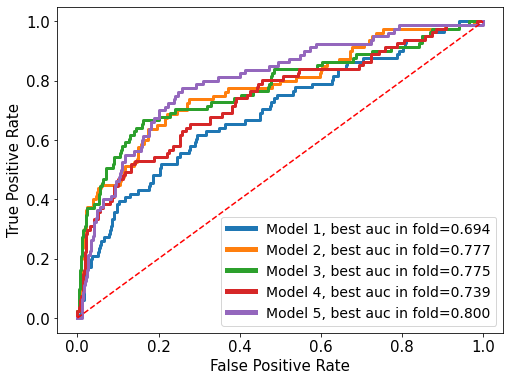

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.plot(best_auc_model1[0],best_auc_model1[1],label="{}, best auc in fold={:.3f}".format("Model 1",best_auc_model1[2]),linewidth=3)
plt.plot(best_auc_model2[0],best_auc_model2[1],label="{}, best auc in fold={:.3f}".format("Model 2",best_auc_model2[2]),linewidth=3)
plt.plot(best_auc_model3[0],best_auc_model3[1],label="{}, best auc in fold={:.3f}".format("Model 3",best_auc_model3[2]),linewidth=3)
plt.plot(best_auc_model4[0],best_auc_model4[1],label="{}, best auc in fold={:.3f}".format("Model 4",best_auc_model4[2]),linewidth=3)
plt.plot(best_auc_model5[0],best_auc_model5[1],label="{}, best auc in fold={:.3f}".format("Model 5",best_auc_model5[2]),linewidth=3)
# plt.title('Perbandingan Grafik ROC pada Variasi Penggunaan Fitur Protein', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:  
    legobj.set_linewidth(5.0)
plt.show()

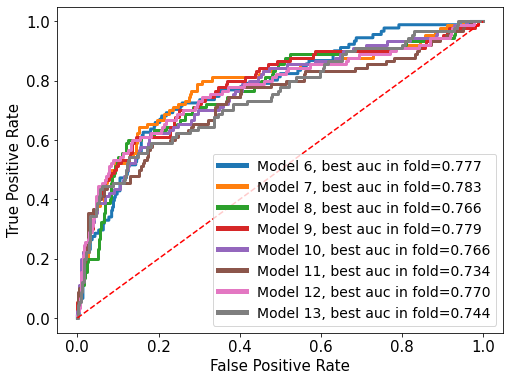

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.plot(best_auc_model6[0],best_auc_model6[1],label="{}, best auc in fold={:.3f}".format("Model 6",best_auc_model6[2]),linewidth=3)
plt.plot(best_auc_model7[0],best_auc_model7[1],label="{}, best auc in fold={:.3f}".format("Model 7",best_auc_model7[2]),linewidth=3)
plt.plot(best_auc_model8[0],best_auc_model8[1],label="{}, best auc in fold={:.3f}".format("Model 8",best_auc_model8[2]),linewidth=3)
plt.plot(best_auc_model9[0],best_auc_model9[1],label="{}, best auc in fold={:.3f}".format("Model 9",best_auc_model9[2]),linewidth=3)
plt.plot(best_auc_model10[0],best_auc_model10[1],label="{}, best auc in fold={:.3f}".format("Model 10",best_auc_model10[2]),linewidth=3)
plt.plot(best_auc_model11[0],best_auc_model11[1],label="{}, best auc in fold={:.3f}".format("Model 11",best_auc_model11[2]),linewidth=3)
plt.plot(best_auc_model12[0],best_auc_model12[1],label="{}, best auc in fold={:.3f}".format("Model 12",best_auc_model12[2]),linewidth=3)
plt.plot(best_auc_model13[0],best_auc_model13[1],label="{}, best auc in fold={:.3f}".format("Model 13",best_auc_model13[2]),linewidth=3)
# plt.title('Perbandingan Grafik ROC pada Variasi Penggunaan Fitur Protein', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:  
    legobj.set_linewidth(5.0)
plt.show()

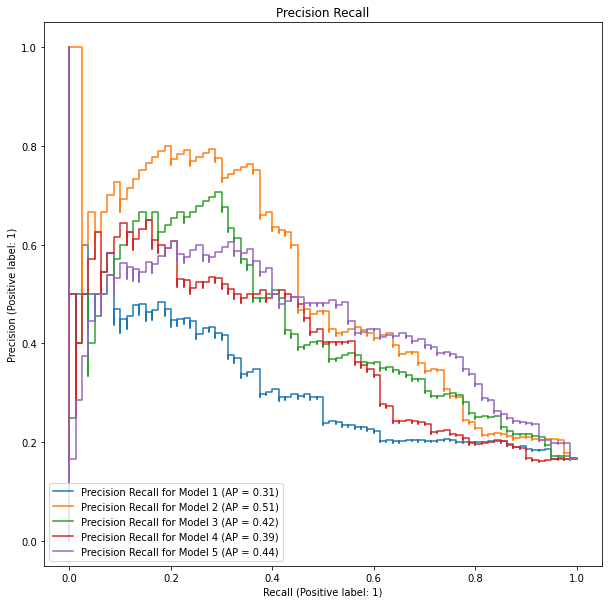

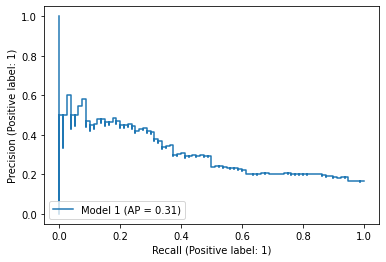

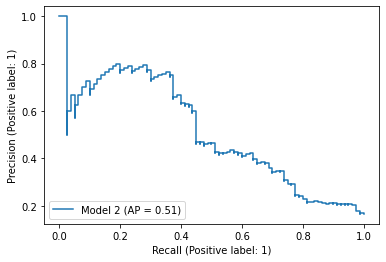

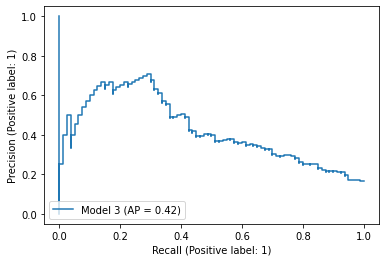

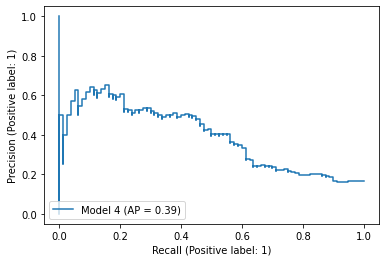

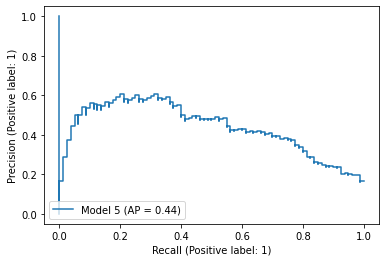

In [124]:
from sklearn.metrics import PrecisionRecallDisplay


_, ax = plt.subplots(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y_test_model1, yhat_model1, name="Model 1")
display.plot(ax = ax, name = 'Precision Recall for Model 1')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model2, yhat_model2, name="Model 2")
display.plot(ax = ax, name = 'Precision Recall for Model 2')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model3, yhat_model3, name="Model 3")
display.plot(ax = ax, name = 'Precision Recall for Model 3')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model4, yhat_model4, name="Model 4")
display.plot(ax = ax, name = 'Precision Recall for Model 4')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model5, yhat_model5, name="Model 5")
display.plot(ax = ax, name = 'Precision Recall for Model 5')
_ = display.ax_.set_title("Precision Recall")
plt.show()

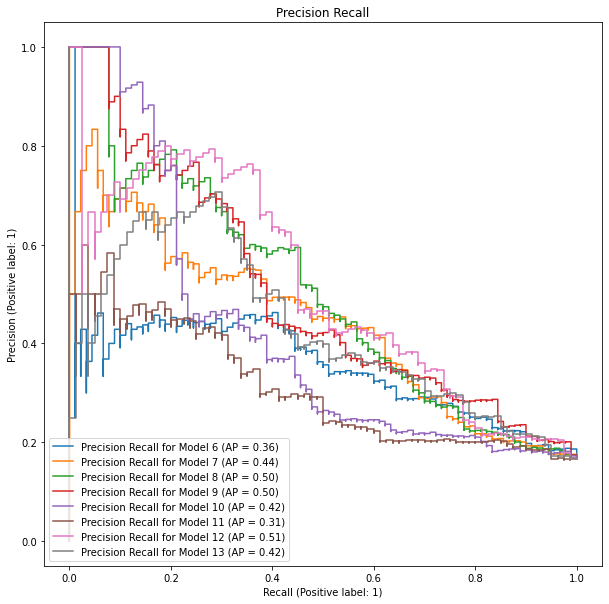

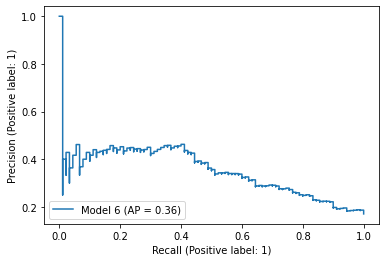

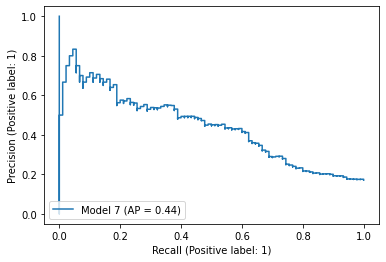

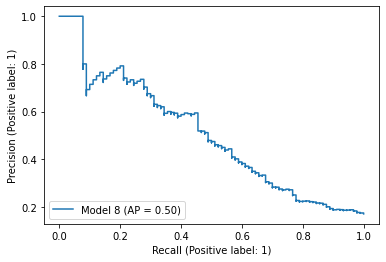

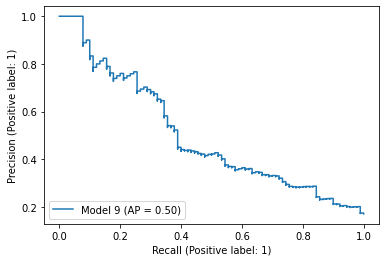

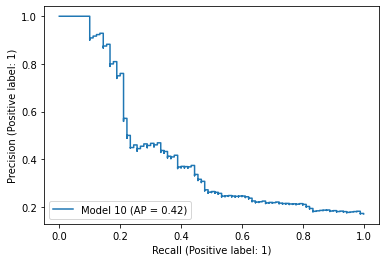

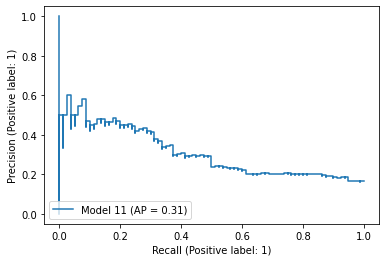

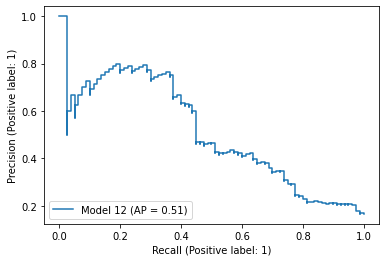

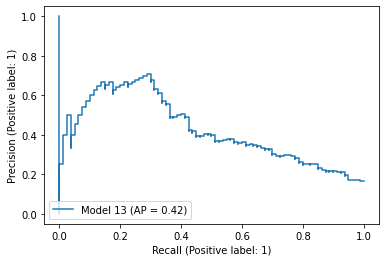

In [126]:
from sklearn.metrics import PrecisionRecallDisplay


_, ax = plt.subplots(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y_test_model6, yhat_model6, name="Model 6")
display.plot(ax = ax, name = 'Precision Recall for Model 6')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model7, yhat_model7, name="Model 7")
display.plot(ax = ax, name = 'Precision Recall for Model 7')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model8, yhat_model8, name="Model 8")
display.plot(ax = ax, name = 'Precision Recall for Model 8')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model9, yhat_model9, name="Model 9")
display.plot(ax = ax, name = 'Precision Recall for Model 9')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model10, yhat_model10, name="Model 10")
display.plot(ax = ax, name = 'Precision Recall for Model 10')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model1, yhat_model1, name="Model 11")
display.plot(ax = ax, name = 'Precision Recall for Model 11')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model2, yhat_model2, name="Model 12")
display.plot(ax = ax, name = 'Precision Recall for Model 12')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model3, yhat_model3, name="Model 13")
display.plot(ax = ax, name = 'Precision Recall for Model 13')
_ = display.ax_.set_title("Precision Recall")
plt.show()

In [127]:
res_all_combine = [res_all_model1,res_all_model2,res_all_model3,res_all_model4,res_all_model5]
res_all_combine

[[[0.822680412371134,
   0.8206185567010309,
   0.8206185567010309,
   0.8309278350515464,
   0.8326446280991735],
  [0.1728395061728395,
   0.19753086419753085,
   0.09876543209876543,
   0.07407407407407407,
   0.1375],
  [0.42424242424242425,
   0.42105263157894735,
   0.36363636363636365,
   0.46153846153846156,
   0.4782608695652174],
  [0.6480870309253148,
   0.6002628040581836,
   0.6466507761887299,
   0.6937110377704437,
   0.6510519801980199],
  [0.2456140350877193,
   0.2689075630252101,
   0.1553398058252427,
   0.12765957446808512,
   0.21359223300970873]],
 [[0.8329896907216495,
   0.843298969072165,
   0.822680412371134,
   0.7917525773195876,
   0.8657024793388429],
  [0.24691358024691357,
   0.2962962962962963,
   0.4074074074074074,
   0.35802469135802467,
   0.4],
  [0.5,
   0.5581395348837209,
   0.4647887323943662,
   0.3717948717948718,
   0.6530612244897959],
  [0.6915719349712749,
   0.7291590270138125,
   0.7433687813225767,
   0.6753453123090086,
   0.77654702

In [132]:
res_model1 = pd.DataFrame(res_all_combine[0], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model2 = pd.DataFrame(res_all_combine[1], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model3 = pd.DataFrame(res_all_combine[2], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model4 = pd.DataFrame(res_all_combine[3], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model5 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model1["Dataset"] = ["Model 1" for i in range(res_model1.shape[0])]
res_model2["Dataset"] = ["Model 2" for i in range(res_model2.shape[0])]
res_model3["Dataset"] = ["Model 3" for i in range(res_model3.shape[0])]
res_model4["Dataset"] = ["Model 4" for i in range(res_model4.shape[0])]
res_model5["Dataset"] = ["Model 5" for i in range(res_model5.shape[0])]

res_combine = pd.concat([res_model1,res_model2,res_model3,res_model4,res_model5], axis = 0)

<Figure size 720x576 with 0 Axes>

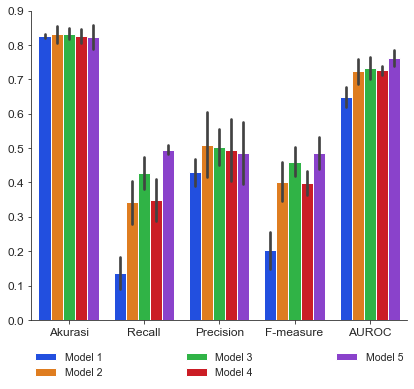

In [133]:
df_res = res_combine.copy()
df_res = pd.melt(df_res, id_vars=["Dataset"], value_vars=["Akurasi","Recall","Precision","F-measure","AUROC"])

import seaborn as sns
sns.set_style("ticks")
plt.figure(figsize = (10,8))
g = sns.catplot(x="variable", y="value", hue="Dataset", data=df_res, height=5, kind="bar", palette="bright", aspect = 1.2, legend = False, ci = "sd")
plt.legend(bbox_to_anchor=(0., -.2, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., frameon = False, prop={'size': 10.5})
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
g.set_xlabels("")
g.set_ylabels("")

In [140]:
res_all_combine = [res_all_model6,res_all_model7,res_all_model8,res_all_model9,res_all_model10,res_all_model11,res_all_model12,res_all_model13]
res_all_combine

[[[0.7996219281663516,
   0.8034026465028355,
   0.8049242424242424,
   0.8068181818181818,
   0.8087121212121212],
  [0.5604395604395604,
   0.38461538461538464,
   0.3333333333333333,
   0.4777777777777778,
   0.4111111111111111],
  [0.4358974358974359,
   0.42168674698795183,
   0.410958904109589,
   0.4387755102040816,
   0.43529411764705883],
  [0.7765442320236841,
   0.7209217722916352,
   0.7218036529680364,
   0.7471714865550482,
   0.7276889903602232],
  [0.49038461538461536,
   0.40229885057471265,
   0.36809815950920244,
   0.45744680851063835,
   0.4228571428571428]],
 [[0.7844990548204159,
   0.831758034026465,
   0.8162878787878788,
   0.8162878787878788,
   0.8428030303030303],
  [0.26373626373626374,
   0.4175824175824176,
   0.5222222222222223,
   0.4,
   0.18888888888888888],
  [0.3380281690140845,
   0.5135135135135135,
   0.46534653465346537,
   0.45569620253164556,
   0.6296296296296297],
  [0.7171960459631693,
   0.714486426815194,
   0.7833840690005074,
   0.7278

In [146]:
res_model6 = pd.DataFrame(res_all_combine[0], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model7 = pd.DataFrame(res_all_combine[1], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model8 = pd.DataFrame(res_all_combine[2], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model9 = pd.DataFrame(res_all_combine[3], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model10 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model11 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model12 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model13 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model6["Dataset"] = ["Model 6" for i in range(res_model6.shape[0])]
res_model7["Dataset"] = ["Model 7" for i in range(res_model7.shape[0])]
res_model8["Dataset"] = ["Model 8" for i in range(res_model8.shape[0])]
res_model9["Dataset"] = ["Model 9" for i in range(res_model9.shape[0])]
res_model0["Dataset"] = ["Model 10" for i in range(res_model0.shape[0])]
res_model11["Dataset"] = ["Model 11" for i in range(res_model11.shape[0])]
res_model12["Dataset"] = ["Model 12" for i in range(res_model12.shape[0])]
res_model13["Dataset"] = ["Model 13" for i in range(res_model13.shape[0])]
res_combine = pd.concat([res_model6,res_model7,res_model8,res_model9,res_model10,res_model11,res_model12,res_model13], axis = 0)

<Figure size 720x576 with 0 Axes>

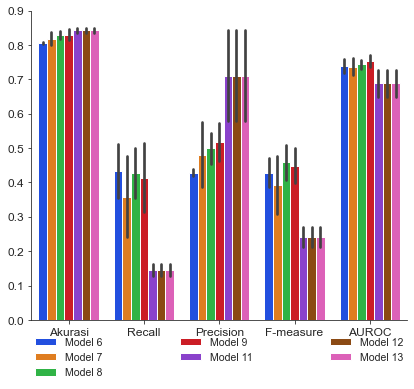

In [147]:
df_res = res_combine.copy()
df_res = pd.melt(df_res, id_vars=["Dataset"], value_vars=["Akurasi","Recall","Precision","F-measure","AUROC"])

import seaborn as sns
sns.set_style("ticks")
plt.figure(figsize = (10,8))
g = sns.catplot(x="variable", y="value", hue="Dataset", data=df_res, height=5, kind="bar", palette="bright", aspect = 1.2, legend = False, ci = "sd")
plt.legend(bbox_to_anchor=(0., -.2, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., frameon = False, prop={'size': 10.5})
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
g.set_xlabels("")
g.set_ylabels("")